<a href="https://colab.research.google.com/github/MegaKruk/PWr-SMA-Project/blob/master/SMA_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/online_retail_II.xlsx')

print(list(df.columns.values)  )
print(len(df))

['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
525461


Drop Unused coloumns

In [0]:
df = df.drop(["Customer ID", "StockCode", "Description","Invoice"], axis=1)


*   Cleaning data (drop row if quantity < 0)
*   add new colomn for sales (quantity * price)




In [0]:
df = df.drop(df[df.Quantity < 0].index)
df['Sales'] = df.Price * df.Quantity # adds new column Sales = price * quantity
df = df.drop(["Price", "Quantity"], axis=1)


Add Week coloumn

In [0]:
df.InvoiceDate.value_counts()
df['date_week'] = df['InvoiceDate'].apply(lambda x: x.isocalendar()[1])
df['date_year'] = df['InvoiceDate'].apply(lambda x: x.isocalendar()[0])


See how many sales happen for each country
![alt text](https://)



In [0]:
UK_count_sales = df.groupby([df['Country']=="United Kingdom"]
                          )['Sales'].count()
print(UK_count_sales.head())

Country
False     45000
True     486286
Name: Sales, dtype: int64


Split data by country UK and non UK


In [0]:
UK_sales  = df[df['Country'] == 'United Kingdom']
print(UK_sales.head(3))

          InvoiceDate         Country  Sales  date_week  date_year
0 2010-12-01 08:26:00  United Kingdom  15.30         48       2010
1 2010-12-01 08:26:00  United Kingdom  20.34         48       2010
2 2010-12-01 08:26:00  United Kingdom  22.00         48       2010


In [0]:
NUK_sales = df[df['Country'] != 'United Kingdom']
print(NUK_sales.head(3))

           InvoiceDate Country  Sales  date_week  date_year
26 2010-12-01 08:45:00  France   90.0         48       2010
27 2010-12-01 08:45:00  France   90.0         48       2010
28 2010-12-01 08:45:00  France   45.0         48       2010


# UK Sales Forecasting (weekly ) with ARIMA

   date_year  date_week  Total_sales
0       2010         48    169550.50
1       2010         49    303552.03
2       2010         50    198597.17


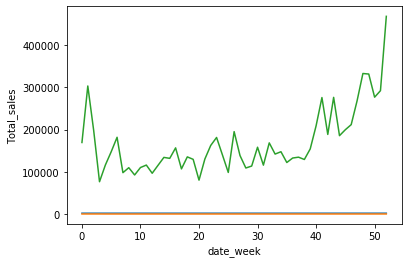

In [0]:
#grafic for total Sales  everyweek
week_s = UK_sales.groupby([df['date_year'],df['date_week']]
                          )['Sales'].sum().reset_index(name ='Total_sales')
print(week_s.head(3))
plt.xlabel('date_week')
plt.ylabel('Total_sales')
plt.plot(week_s)
plt.show()


Check the stationary of the data

In [0]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(week_s.Total_sales.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.729768
p-value: 0.998199


Differencing - since P value >0.05

In [0]:
#Function to prouce the plot to see the difference
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Total_sales'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

Using rolling mean differencing

In [0]:
df_log = np.log(week_s)
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

ADF Statistic: -4.335871258557178
p-value: 0.00038479178322754266
Critical Values:
	1%: -3.60098336718852
	5%: -2.9351348158036012
	10%: -2.6059629803688282


In [0]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(2,0,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

NameError: ignored

In [0]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Total_sales'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

NameError: ignored

Simple Moving Average for stores in UK
Dickey Fuller Test Results for UK:
Test Statistic                  0.000512
p-value                         0.958574
#Lags Used                      7.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
dtype: float64
Test Statistic                  0.000512
p-value                         0.958574
#Lags Used                      7.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
dtype: float64
Test Statistic                  0.000512
p-value                         0.958574
#Lags Used                      7.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64
Simple Moving Average for stores not in UK
Dickey Fuller Test Results for non-UK:
Test Statistic                 -3.790913
p-value             

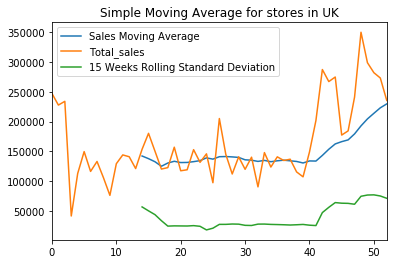

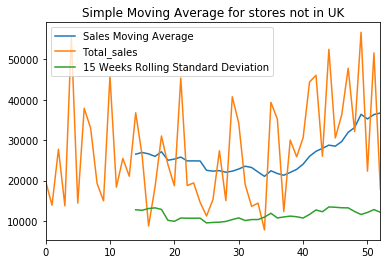

In [0]:
# i had to dup this code, for some reason it wouldn't work otherwise
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('online_retail_II.xlsx')
df = df.drop(["Customer ID", "StockCode", "Description","Invoice"], axis=1)
df = df.drop(df[df.Quantity < 0].index)
df['Sales'] = df.Price * df.Quantity # adds new column Sales = price * quantity
df = df.drop(["Price", "Quantity"], axis=1)
df.InvoiceDate.value_counts()
df['date_week'] = df['InvoiceDate'].apply(lambda x: x.isocalendar()[1])
df['date_year'] = df['InvoiceDate'].apply(lambda x: x.isocalendar()[0])
UK_count_sales = df.groupby([df['Country']=="United Kingdom"])['Sales'].count()
UK_sales = df[df['Country'] == 'United Kingdom']
NUK_sales = df[df['Country'] != 'United Kingdom']
week_s_UK = UK_sales.groupby([df['date_year'],df['date_week']])['Sales'].sum().reset_index(name ='Total_sales')
week_s_NUK = NUK_sales.groupby([df['date_year'],df['date_week']])['Sales'].sum().reset_index(name ='Total_sales')
#print(week_s_UK)
#print(week_s_NUK)

# Simple Moving Average
print('Simple Moving Average for stores in UK')
week_s_UK['Sales Moving Average'] = week_s_UK['Total_sales'].rolling(15).mean()
week_s_UK.plot(kind='line', y= ['Sales Moving Average', 'Total_sales'])
week_s_UK['Total_sales'].rolling(15).std().plot(label='15 Weeks Rolling Standard Deviation')
plt.title('Simple Moving Average for stores in UK')
plt.legend()
# Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
print('Dickey Fuller Test Results for UK:')
dftest = adfuller(week_s_UK['Total_sales'], autolag='AIC')
dfres = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for a, b in dftest[4].items():
    dfres['Critical Value (%s)'%a] = b
    print(dfres)

print('Simple Moving Average for stores not in UK')
week_s_NUK['Sales Moving Average'] = week_s_NUK['Total_sales'].rolling(15).mean()
week_s_NUK.plot(kind='line', y= ['Sales Moving Average', 'Total_sales'])
week_s_NUK['Total_sales'].rolling(15).std().plot(label='15 Weeks Rolling Standard Deviation')
plt.title('Simple Moving Average for stores not in UK')
plt.legend()
# Dickey Fuller Test
print('Dickey Fuller Test Results for non-UK:')
dftest2 = adfuller(week_s_NUK['Total_sales'], autolag='AIC')
dfres2 = pd.Series(dftest2[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for a,b in dftest2[4].items():
    dfres2['Critical Value (%s)'%a] = b
    print(dfres2)

